In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from deepalign import fs
from deepalign.utils import microsoft_colors

%config InlineBackend.figure_format = 'retina'

First, let us create some helper functions to prettify our evaluation dataframe.

In [2]:
datasets = {'paper': 'Paper', 'p2p': 'P2P', 'huge': 'Huge', 'small': 'Small', 'medium': 'Medium', 'wide': 'Wide'}
algorithms = {'confnet00': r'DeepAlign0', 'confnet10': 'DeepAlignE', 
              'optimal': 'Reference Model', 'im': 'Inductive Miner', 'hm': 'Heuristics Miner'}

binary_label_order = ['Normal', 'Anomalous']
label_order = ['Normal', 'Skip', 'Rework', 'Insert', 'Early', 'Late', 'Attribute']
model_order = ['P2P', 'Small', 'Medium', 'Huge', 'Wide']
alg_order = ['Reference Model', 'Heuristics Miner', 'Inductive Miner', 'DeepAlign0', 'DeepAlignE']

def prettify_dataframe(base_df):
    df = base_df.copy()

    lookup = {
        'process_model': datasets,
        'algorithm': algorithms,
        'label': {'SkipSequence': 'Skip'}
    }

    for key, value in lookup.items():
        if key in df:
            df[key] = df[key].replace(value)

    return df

Now, let us load the evaluation dataframe from the Excel file.

In [3]:
evaluation = pd.read_excel(str(fs.OUT_DIR / 'evaluation.xlsx'))
evaluation = evaluation[evaluation.columns[1:]] # Remove index column

We are evaluating for `top-k=1` (i.e., only the top-1 prediction), noise levels with `0 < p < 1`, and we are excluding the `Paper` process because it is only used for demonstration.

In [4]:
eval_df = prettify_dataframe(evaluation)
eval_df = eval_df.query('k == 1 and 0 < p < 1 and process_model != "Paper"')

The evaluation file holds the numbers for each anomaly label. We will have to aggregate these numbers to calculate the correct $F_1$ scores.

In [5]:
# Our base dataframe
df = eval_df

# Aggregate based on binary label. This will weigh `Normal` and `Anomalous` one to one.
aggs = {'num_correct': 'sum', 'num_incorrect': 'sum', 'optimality': 'mean', 'error': 'mean'}
df = df.groupby(['algorithm', 'dataset', 'process_model', 'p', 'binary_label']).agg(aggs).reset_index()
df = df.pivot_table(index=['algorithm', 'dataset', 'process_model', 'p'], 
                    columns='binary_label', 
                    values=['num_correct', 'num_incorrect', 'error', 'optimality']).reset_index()

# Aggregate the error values
df['error_normal'] = df['error', 'Normal'].fillna(0)
df['error_anomalous'] = df['error', 'Anomalous'].fillna(0)
del df['error']
df['error'] = (df['error_normal'] + df['error_anomalous']) / 2

# Aggregate the optimality values
df['optimality_normal'] = df['optimality', 'Normal'].fillna(1)
df['optimality_anomalous'] = df['optimality', 'Anomalous'].fillna(1)
del df['optimality']
df['optimality'] = (df['optimality_normal'] + df['optimality_anomalous']) / 2

# Fill `NaN` values with 0
df = df.fillna(0)

# Calculate F1 scores
df['precision_normal'] = df['num_correct', 'Normal'] / (df['num_correct', 'Normal'] + df['num_incorrect', 'Normal'])
df['recall_normal'] = df['num_correct', 'Normal'] / (df['num_correct', 'Normal'] + df['num_incorrect', 'Anomalous'])
df['f1_normal'] = 2 * df['precision_normal'] * df['recall_normal'] / (df['precision_normal'] + df['recall_normal'])

df['precision_anomalous'] = df['num_correct', 'Anomalous'] / (df['num_correct', 'Anomalous'] + df['num_incorrect', 'Anomalous'])
df['recall_anomalous'] = df['num_correct', 'Anomalous'] / (df['num_correct', 'Anomalous'] + df['num_incorrect', 'Normal'])
df['f1_anomalous'] = 2 * df['precision_anomalous'] * df['recall_anomalous'] / (df['precision_anomalous'] + df['recall_anomalous'])

del df['num_correct']
del df['num_incorrect']

df['f1'] = (df['f1_normal'] + df['f1_anomalous']) / 2

# Flatten the column index
df.columns = [c[0] for c in df.columns]

# Tables

### Table 1 in the paper

In [6]:
v = ['f1_normal', 'f1_anomalous', 'f1', 'error', 'optimality']
f = ['{:.2f}', '{:.2f}', '{:.4f}', '{:.2f}', '{:.1%}']
f = dict(zip(v, f))

# Pivot table
p = pd.pivot_table(df, index=['algorithm'], values=v)

# Sort columns
p = p[v]
p = p.loc[alg_order]

# Style output
s = p.style
s = s.format(f)
style = 'background-color: #243996; font-weight: 600; color: yellow'
s = s.apply(lambda s: [style if v else '' for v in s == s.max()], subset=pd.IndexSlice[:, ['f1', 'f1_normal', 'f1_anomalous']], axis=0)
s = s.apply(lambda s: [style if v else '' for v in s == s.min()], subset=pd.IndexSlice[:, ['error']], axis=0)
s = s.apply(lambda s: [style if v else '' for v in s == s[3:].max()], subset=pd.IndexSlice[:, ['optimality']], axis=0)
s

,f1_normal,f1_anomalous,f1,error,optimality
algorithm,,,,,
Reference Model,0.98,0.94,0.9562,1.68,100.0%
Heuristics Miner,0.88,0.68,0.7822,2.31,100.0%
Inductive Miner,0.73,0.22,0.4751,2.26,100.0%
DeepAlign0,0.92,0.80,0.8594,2.93,99.9%
DeepAlignE,0.99,0.97,0.9779,2.09,89.5%


### Other tables 

We can also evaluate the $F_1$ score per dataset. Best results are shown in yellow font color.

In [7]:
p = pd.pivot_table(df, index=['algorithm'], columns=['process_model'], values='f1')
p = p.loc[alg_order]
s = p.style
s = s.format('{:.4f}')
s = s.background_gradient('YlGnBu', axis=None)
s = s.apply(lambda s: ['font-weight: 600; color: yellow' if v else '' for v in s == s.max()], axis=0)
s

process_model,Huge,Medium,P2P,Small,Wide
algorithm,,,,,
Reference Model,0.9595,0.9473,0.9159,0.9822,0.9763
Heuristics Miner,0.7830,0.6051,0.8513,0.8735,0.7978
Inductive Miner,0.4649,0.5582,0.5599,0.2256,0.5668
DeepAlign0,0.8997,0.8220,0.7179,0.9604,0.8968
DeepAlignE,0.9837,0.9862,0.9432,0.9928,0.9833


Or, we can evaluate per noise ratio, i.e., percentage of cases affected by an anomaly.

In [8]:
p = pd.pivot_table(df, index=['algorithm'], columns=['p'], values='f1')
p = p.loc[alg_order]
p.columns = ['{:.0%}'.format(c) for c in p.columns]
s = p.style
s = s.format('{:.4f}')
s = s.background_gradient('YlGnBu', axis=None)
s = s.apply(lambda s: ['font-weight: 600; color: yellow' if v else '' for v in s == s.max()], axis=0)
s

,30%
algorithm,
Reference Model,0.9562
Heuristics Miner,0.7822
Inductive Miner,0.4751
DeepAlign0,0.8594
DeepAlignE,0.9779


## Plots

This line will set the Seaborn context for paper quality figures, as well as the style.

In [9]:
sns.set_style('white')
sns.set_context('paper')

### Figure 8 in the paper

Let us plot the results from the tables above in one combined figure.

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (9).

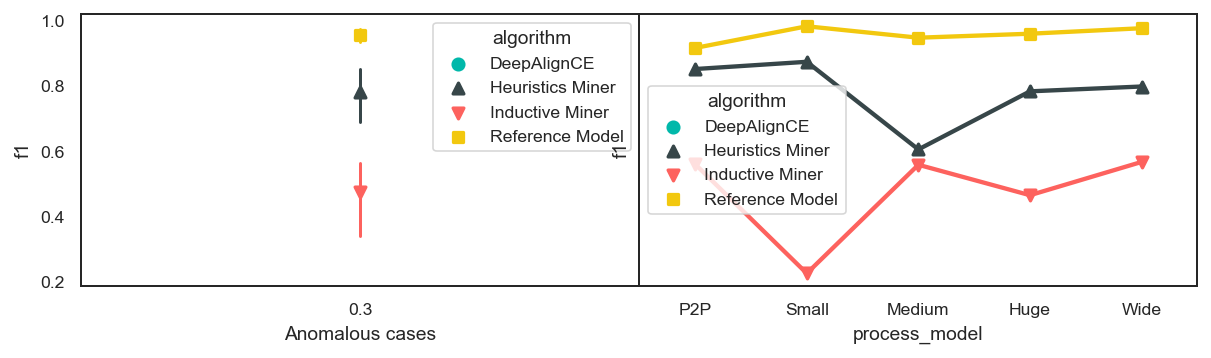

In [10]:
ho = ['DeepAlignCE', 'Heuristics Miner', 'Inductive Miner', 'Reference Model']
markers = ["o", "^", 'v', 's']

fig, (a0, a1) = plt.subplots(1, 2, sharey=True, figsize=((10, 2.5)), gridspec_kw={'wspace': 0.0})

g0 = sns.pointplot(data=df.query(f'algorithm in {str(ho)}'), x='p', y='f1', 
                  hue='algorithm', markers=markers, errwidth=1.5, capsize=0.0,
                  palette=microsoft_colors[:len(ho)], hue_order=ho, ax=a0, legend=False)

g1 = sns.pointplot(data=df.query(f'algorithm in {str(ho)}'), x='process_model', y='f1', 
                  hue='algorithm', markers=markers, errwidth=1.5, capsize=0.0,
                  palette=microsoft_colors[:len(ho)], hue_order=ho, order=model_order, ax=a1, legend=False)

a0.set_xlabel('Anomalous cases')
a0.set_xticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
a0.set_ylabel(r'$F_{1}$')

a1.set_xlabel('Dataset')
a1.set_ylabel('')

a0.legend_.remove()
_ = a1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., frameon=False)

# plt.tight_layout()
# plt.savefig('evaluation.pdf')

### Other plots

We can also use bar charts to visualize the same results.

In [ ]:
hue_order = ['DeepAlign0', 'DeepAlignC', 'DeepAlignE', 'DeepAlignCE', 'Heuristics Miner', 'Inductive Miner', 'Reference Model']

fig = plt.subplots(figsize=(12, 3))
g = sns.barplot(data=df, x='process_model', y='f1', hue='algorithm', palette=microsoft_colors[:7], hue_order=hue_order, order=model_order)
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

fig = plt.subplots(figsize=(12, 3))
g = sns.barplot(data=df, x='p', y='f1', hue='algorithm', palette=microsoft_colors[:7], hue_order=hue_order)
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)